`Name:` **Deven Dhake**  
`PRN:` **22070126033**  
`Class:` **AIML A2**  
`Assignment No.:` **5**  
`GitHub:`  **https://github.com/Devendhake18/NLP_Assignments**  


# *T5 Model :*

In [1]:
# Import necessary libraries
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
import nltk

# Download NLTK data for BLEU score calculation
nltk.download('punkt')

# Ignore Warnings
import logging
logging.disable(logging.WARNING)

c:\Users\deven\miniconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\deven\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def load_coqa_data(file_path):
    # Load CoQA dataset from a JSON file
    with open(file_path, 'r') as f:
        data = json.load(f)  # Read JSON data
    return data['data']  # Return the 'data' field from the JSON

# Custom dataset class for CoQA
class CoQADataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        # Initialize dataset with data, tokenizer, and max sequence length
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve the item at index idx
        item = self.data[idx]
        context = item['story']  # Extract the story context
        question = item['questions'][0]['input_text']  # Extract the question
        answer = item['answers'][0]['input_text']  # Extract the answer

        # Format input for T5: "question: <question> context: <context>"
        input_text = f"question: {question} context: {context}"
        target_text = answer  # The target output is the answer

        # Tokenize the input and target texts
        inputs = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'  # Return as PyTorch tensors
        )

        labels = self.tokenizer(
            target_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'  # Return as PyTorch tensors
        )

        # Return a dictionary with input IDs, attention mask, and labels
        return {
            'input_ids': inputs['input_ids'].flatten(),  # Flatten to 1D
            'attention_mask': inputs['attention_mask'].flatten(),  # Flatten to 1D
            'labels': labels['input_ids'].flatten()  # Flatten to 1D for T5 labels
        }

In [3]:
# Load and split the data
data = load_coqa_data(r'D:\New folder\CODDING STUFF\Sem 5\NLPL\Assignment 5\Question_Answering-20241016\coqa-train-v1.0.json')
# Split the data into training (70%), validation (15%), and test (15%) sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)


In [4]:
# Initialize tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-small')  # Load T5 tokenizer

# Create datasets for training, validation, and testing
train_dataset = CoQADataset(train_data, tokenizer)
val_dataset = CoQADataset(val_data, tokenizer)
test_dataset = CoQADataset(test_data, tokenizer)

# Create data loaders for batching
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)


In [5]:
def train(model, train_loader, optimizer, device):
    # Function to train the model for one epoch
    model.train()  # Set model to training mode
    total_loss = 0  # Initialize total loss
    progress_bar = tqdm(train_loader, desc="Training")  # Create a progress bar

    for batch in progress_bar:
        optimizer.zero_grad()  # Zero the gradients

        # Move batch data to the specified device (CPU or GPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass with T5
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Get the loss from the output
        loss = outputs.loss
        total_loss += loss.item()  # Accumulate loss

        # Backward pass and optimization step
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Update progress bar with current loss
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(train_loader)  # Return average loss


In [6]:
# Initialize model and optimizer
model = T5ForConditionalGeneration.from_pretrained('t5-small')  # Load T5 model

# Set device and move model to device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set optimizer with learning rate
optimizer = AdamW(model.parameters(), lr=5e-5)

c:\Users\deven\miniconda3\envs\pytorch_env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [7]:
def validate(model, val_loader, device):
    # Function to validate the model on the validation set
    model.eval()  # Set model to evaluation mode
    total_loss = 0  # Initialize total loss
    progress_bar = tqdm(val_loader, desc="Validating")  # Create a progress bar

    with torch.no_grad():  # Disable gradient computation
        for batch in progress_bar:
            # Move batch data to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass with T5
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss  # Get loss
            total_loss += loss.item()  # Accumulate loss

            progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(val_loader)  # Return average loss


In [8]:
# Test function to evaluate the model on the test set
def test(model, test_loader, tokenizer, device):
    model.eval()  # Set model to evaluation mode
    all_predictions = []  # List to store predictions
    all_answers = []  # List to store true answers
    progress_bar = tqdm(test_loader, desc="Testing")  # Create a progress bar

    with torch.no_grad():  # Disable gradient computation
        for batch in progress_bar:
            # Move batch data to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Generate answer using T5
            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=50, num_beams=5, early_stopping=True)
            prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)  # Decode the prediction

            # Collect the predictions
            all_predictions.append(prediction)

            # Decode the true answer for BLEU score calculation
            true_answer = tokenizer.decode(batch['labels'][0], skip_special_tokens=True)
            all_answers.append(true_answer)

    # Calculate BLEU score based on predictions and true answers
    bleu_score = calculate_bleu(all_predictions, all_answers)
    return bleu_score


In [9]:
# Set number of training epochs
num_epochs = 3
best_loss = float('inf')  # Initialize best loss for model saving

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train(model, train_loader, optimizer, device)  # Train for one epoch
    val_loss = validate(model, val_loader, device)  # Validate after training
    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    # Save the model if validation loss has improved
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 't5_qa_model.pth')  # Save the model state
        print("Model saved!")
    else:
        print("Validation Loss Increased. Model Not Saved.")
    print("*" * 50)

Epoch 1/3


Validating: 100%|██████████| 135/135 [00:20<00:00,  6.61it/s, loss=0.0598]


Train Loss: 0.7373, Validation Loss: 0.0620
Model saved!
**************************************************
Epoch 2/3


Validating: 100%|██████████| 135/135 [00:20<00:00,  6.64it/s, loss=0.0185]


Train Loss: 0.0473, Validation Loss: 0.0216
Model saved!
**************************************************
Epoch 3/3


Validating: 100%|██████████| 135/135 [00:20<00:00,  6.64it/s, loss=0.0118] 


Train Loss: 0.0211, Validation Loss: 0.0127
Model saved!
**************************************************


In [10]:
# Calculate BLEU score
def calculate_bleu(predictions, references):
    # Function to calculate the average BLEU score for the predictions
    bleu_scores = []
    for pred, ref in zip(predictions, references):
        # Compute BLEU score for each prediction-reference pair
        bleu_scores.append(sentence_bleu([ref.split()], pred.split()))  # Split strings into words
    return sum(bleu_scores) / len(bleu_scores)  # Return average BLEU score


In [11]:
# Test the model and compute BLEU score
bleu_score = test(model, test_loader, tokenizer, device)
print(f"BLEU Score: {bleu_score:.4f}")

Testing: 100%|██████████| 135/135 [00:44<00:00,  3.06it/s]

BLEU Score: 0.0583



c:\Users\deven\miniconda3\envs\pytorch_env\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\deven\miniconda3\envs\pytorch_env\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\deven\miniconda3\envs\pytorch_env\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using

# *Distilbert Model:*

In [12]:
# Import necessary libraries
import json  # For loading JSON data
import torch  # Main library for tensor operations and deep learning
from torch.utils.data import Dataset, DataLoader  # For creating datasets and loading data in batches
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering, AdamW  # For the DistilBERT model and tokenizer
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and test sets
from tqdm import tqdm  # For progress bars during training and evaluation
from nltk.translate.bleu_score import sentence_bleu  # For calculating the BLEU score
import nltk  # Natural Language Toolkit


In [13]:
def load_coqa_data(file_path):
    """Load CoQA dataset from a JSON file."""
    with open(file_path, 'r') as f:
        data = json.load(f)  # Read JSON data into a Python dictionary
    return data['data']  # Return the 'data' key from the JSON

class CoQADataset(Dataset):
    """Custom dataset class for CoQA."""

    def __init__(self, data, tokenizer, max_length=512):
        """
        Initialize the dataset.
        
        Args:
            data: List of CoQA data entries.
            tokenizer: Tokenizer for the model.
            max_length: Maximum length for tokenization.
        """
        self.data = data  # Store the data
        self.tokenizer = tokenizer  # Store the tokenizer
        self.max_length = max_length  # Set maximum length for input sequences

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Retrieve an item from the dataset."""
        item = self.data[idx]  # Get the data entry at index idx
        context = item['story']  # Extract the story context
        question = item['questions'][0]['input_text']  # Extract the first question
        answer = item['answers'][0]['input_text']  # Extract the first answer

        # Tokenize the input question and context
        inputs = self.tokenizer.encode_plus(
            question,
            context,
            add_special_tokens=True,  # Add [CLS] and [SEP] tokens
            max_length=self.max_length,
            padding='max_length',  # Pad sequences to max_length
            truncation=True,  # Truncate sequences longer than max_length
            return_tensors='pt'  # Return as PyTorch tensors
        )

        # Find the start and end positions of the answer in the tokenized input
        input_ids = inputs['input_ids'][0]  # Get the input IDs for the first entry
        answer_tokens = self.tokenizer.encode(answer, add_special_tokens=False)  # Encode the answer without special tokens
        start_position = None
        end_position = None

        # Search for the answer tokens in the input IDs
        for i in range(len(input_ids) - len(answer_tokens) + 1):
            if input_ids[i:i+len(answer_tokens)].tolist() == answer_tokens:  # Check for a match
                start_position = i  # Set start position
                end_position = i + len(answer_tokens) - 1  # Set end position
                break

        # If the answer is not found, use the CLS token position as a default
        if start_position is None:
            start_position = 0  # Default to the start of the input
            end_position = 0  # Default end position

        # Return a dictionary with the necessary information
        return {
            'input_ids': inputs['input_ids'].flatten(),  # Flatten input IDs to 1D
            'attention_mask': inputs['attention_mask'].flatten(),  # Flatten attention mask to 1D
            'start_positions': torch.tensor(start_position),  # Convert start position to tensor
            'end_positions': torch.tensor(end_position),  # Convert end position to tensor
            'answer': answer  # Store the answer
        }

In [14]:
# Load CoQA data from the specified JSON file
data = load_coqa_data(r'D:\New folder\CODDING STUFF\Sem 5\NLPL\Assignment 5\Question_Answering-20241016\coqa-train-v1.0.json')

# Split the data into training (70%) and test (30%) sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
# Further split the test data into validation (15%) and test (15%) sets
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)


In [15]:
# Initialize the tokenizer for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create datasets for training, validation, and testing
train_dataset = CoQADataset(train_data, tokenizer)
val_dataset = CoQADataset(val_data, tokenizer)
test_dataset = CoQADataset(test_data, tokenizer)

# Create DataLoader instances for batching the datasets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=8)  # No shuffling for validation
test_loader = DataLoader(test_dataset, batch_size=8)  # No shuffling for testing

In [16]:
def train(model, train_loader, optimizer, device):
    """Train the model for one epoch."""
    model.train()  # Set model to training mode
    total_loss = 0  # Initialize total loss
    progress_bar = tqdm(train_loader, desc="Training")  # Create a progress bar

    for batch in progress_bar:
        optimizer.zero_grad()  # Zero the gradients for the optimizer

        # Move batch data to the specified device (CPU or GPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        # Forward pass with DistilBERT
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, 
                        start_positions=start_positions, end_positions=end_positions)

        # Get the loss from the output
        loss = outputs.loss

        # Average loss across GPUs (if using multiple)
        loss = loss.mean()  # In case of distributed training, take the mean loss

        total_loss += loss.item()  # Accumulate loss

        # Backward pass and optimization step
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Update progress bar with current loss
        progress_bar.set_postfix({'loss': loss.item()})

    # Return the average loss over all batches
    return total_loss / len(train_loader)

In [17]:
# Initialize model and optimizer
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')  # Load the pre-trained DistilBERT model

# Set device for training (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move model to the device

# Set optimizer with a learning rate
optimizer = AdamW(model.parameters(), lr=5e-5)  # AdamW optimizer for weight decay

In [18]:
def validate(model, val_loader, device):
    """Validate the model on the validation set."""
    model.eval()  # Set model to evaluation mode
    total_loss = 0  # Initialize total loss
    progress_bar = tqdm(val_loader, desc="Validating")  # Create a progress bar

    with torch.no_grad():  # Disable gradient computation for validation
        for batch in progress_bar:
            # Move batch data to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            # Forward pass with DistilBERT
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, 
                            start_positions=start_positions, end_positions=end_positions)
            loss = outputs.loss  # Get the loss
            total_loss += loss.item()  # Accumulate loss

            progress_bar.set_postfix({'loss': loss.item()})

    # Return average loss over validation batches
    return total_loss / len(val_loader)

In [19]:
# Test function to evaluate the model on the test set
def test(model, test_loader, tokenizer, device):
    """Test the model and calculate BLEU score."""
    model.eval()  # Set model to evaluation mode
    all_predictions = []  # List to store predictions
    all_answers = []  # List to store true answers
    progress_bar = tqdm(test_loader, desc="Testing")  # Create a progress bar

    with torch.no_grad():  # Disable gradient computation during testing
        for batch in progress_bar:
            # Move batch data to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Get the predicted start and end positions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            start_logits = outputs.start_logits  # Start position logits
            end_logits = outputs.end_logits  # End position logits

            # Get predicted start and end positions
            start_positions = torch.argmax(start_logits, dim=1)  # Get index of max start logit
            end_positions = torch.argmax(end_logits, dim=1)  # Get index of max end logit

            # Decode the predicted answer from the context
            for i in range(input_ids.size(0)):
                # Slice the input IDs based on predicted start and end positions
                input_id_slice = input_ids[i][start_positions[i]:end_positions[i] + 1]
                prediction = tokenizer.decode(input_id_slice, skip_special_tokens=True)  # Decode to text
                all_predictions.append(prediction)  # Store prediction

                # Decode the true answer for BLEU score calculation
                true_answer = tokenizer.decode(batch['input_ids'][i][batch['start_positions'][i]:batch['end_positions'][i]+1], skip_special_tokens=True)
                all_answers.append(true_answer)  # Store true answer

    # Calculate BLEU score based on predictions and true answers
    bleu_score = calculate_bleu(all_predictions, all_answers)
    return bleu_score

In [20]:
num_epochs = 3  # Set the number of epochs for training
best_loss = float('inf')  # Initialize the best validation loss as infinity

# Loop through each epoch for training
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train(model, train_loader, optimizer, device)  # Train the model
    val_loss = validate(model, val_loader, device)  # Validate the model
    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")  # Print losses

    # Save the model if validation loss improves
    if val_loss < best_loss:
        best_loss = val_loss  # Update the best loss
        torch.save(model.state_dict(), 'distilbert_qa_model.pth')  # Save model state
        print("Model saved!")
    else:
        print("Validation Loss Increased. Model Not Saved.")
    print("*" * 50)


Epoch 1/3


Validating: 100%|██████████| 135/135 [00:14<00:00,  9.60it/s, loss=2.03] 


Train Loss: 2.8392, Validation Loss: 2.1684
Model saved!
**************************************************
Epoch 2/3


Validating: 100%|██████████| 135/135 [00:13<00:00,  9.68it/s, loss=2.15] 


Train Loss: 1.4930, Validation Loss: 2.1246
Model saved!
**************************************************
Epoch 3/3


Validating: 100%|██████████| 135/135 [00:14<00:00,  9.55it/s, loss=2.85]

Train Loss: 0.7870, Validation Loss: 2.3172
Validation Loss Increased. Model Not Saved.
**************************************************


In [21]:
# Calculate BLEU score
def calculate_bleu(predictions, references):
    """Calculate the average BLEU score for a set of predictions against references."""
    bleu_scores = []  # List to store BLEU scores
    for pred, ref in zip(predictions, references):
        # Calculate BLEU score for each prediction against the reference
        bleu_scores.append(sentence_bleu([ref.split()], pred.split()))  # Use sentence_bleu from nltk
    return sum(bleu_scores) / len(bleu_scores)  # Return average BLEU score

# Test the model and calculate BLEU score
bleu_score = test(model, test_loader, tokenizer, device)
print(f"BLEU Score: {bleu_score:.4f}")  # Print the BLEU score

Testing: 100%|██████████| 135/135 [00:15<00:00,  8.52it/s]


BLEU Score: 0.0331


# *GPT-2 Model:*

In [1]:
# Import necessary libraries
import json  # For loading and working with JSON data
import torch  # Main library for tensor operations and deep learning
from torch.utils.data import Dataset, DataLoader  # For creating custom datasets and loading data in batches
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW  # For GPT-2 model and tokenizer
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and test sets
from tqdm import tqdm  # For progress bars during training and evaluation
from nltk.translate.bleu_score import sentence_bleu  # For calculating BLEU score for evaluating generated text
import nltk  # Natural Language Toolkit

# Download NLTK punkt tokenizer model for sentence tokenization
nltk.download('punkt')

# Disable warning messages from logging
import logging
logging.disable(logging.WARNING)

c:\Users\deven\miniconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\deven\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Function to load the CoQA dataset from a JSON file
def load_coqa_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)  # Load the JSON data into a Python dictionary
    return data['data']  # Return only the 'data' section of the JSON

# Custom dataset class for CoQA
class CoQADataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        """
        Initialize the dataset.

        Args:
            data: List of CoQA data entries.
            tokenizer: Tokenizer for the model (GPT-2).
            max_length: Maximum length for tokenization.
        """
        self.data = data  # Store the dataset entries
        self.tokenizer = tokenizer  # Store the tokenizer
        self.max_length = max_length  # Set the maximum sequence length

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Retrieve an item from the dataset by index."""
        item = self.data[idx]  # Get the data entry at index idx
        context = item['story']  # Extract the story context
        question = item['questions'][0]['input_text']  # Extract the first question
        answer = item['answers'][0]['input_text']  # Extract the first answer

        # Format the input text for the model
        input_text = f"Context: {context} Question: {question} Answer briefly:"
        target_text = answer  # Set the target text (answer)

        # Tokenize the input text and target text
        inputs = self.tokenizer.encode_plus(
            input_text,
            add_special_tokens=True,  # Add special tokens (like <|endoftext|>)
            max_length=self.max_length,
            padding='max_length',  # Pad sequences to max_length
            truncation=True,  # Truncate sequences longer than max_length
            return_tensors='pt'  # Return as PyTorch tensors
        )

        targets = self.tokenizer.encode_plus(
            target_text,
            add_special_tokens=True,  # Add special tokens
            max_length=self.max_length,
            padding='max_length',  # Pad sequences to max_length
            truncation=True,  # Truncate sequences longer than max_length
            return_tensors='pt'  # Return as PyTorch tensors
        )

        # Return a dictionary containing the input IDs, attention masks, and labels
        return {
            'input_ids': inputs['input_ids'].flatten(),  # Flatten the input IDs to 1D
            'attention_mask': inputs['attention_mask'].flatten(),  # Flatten the attention mask to 1D
            'labels': targets['input_ids'].flatten(),  # Flatten the target IDs to 1D
        }


In [3]:
# Load CoQA data from the specified JSON file
data = load_coqa_data(r'D:\New folder\CODDING STUFF\Sem 5\NLPL\Assignment 5\Question_Answering-20241016\coqa-train-v1.0.json')

# Split the data into training (70%) and test (30%) sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Further split the test data into validation (15%) and test (15%) sets
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)


In [4]:
# Initialize the GPT-2 tokenizer and set padding token to end-of-sequence token
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 does not have a dedicated padding token, using EOS instead

# Create dataset instances for training, validation, and testing
train_dataset = CoQADataset(train_data, tokenizer)
val_dataset = CoQADataset(val_data, tokenizer)
test_dataset = CoQADataset(test_data, tokenizer)

# Create DataLoader instances for batching the datasets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Shuffle training data for randomness
val_loader = DataLoader(val_dataset, batch_size=8)  # No shuffling for validation
test_loader = DataLoader(test_dataset, batch_size=8)  # No shuffling for testing


c:\Users\deven\miniconda3\envs\pytorch_env\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
# Initialize the GPT-2 model for language generation
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))  # Resize token embeddings to accommodate padding token

# Set device for training (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the specified device

# Set optimizer with a learning rate
optimizer = AdamW(model.parameters(), lr=5e-5)  # AdamW optimizer for weight decay

c:\Users\deven\miniconda3\envs\pytorch_env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [6]:
# Function to train the model for one epoch
def train(model, train_loader, optimizer, device):
    model.train()  # Set the model to training mode
    total_loss = 0  # Initialize total loss for this epoch
    progress_bar = tqdm(train_loader, desc="Training")  # Create a progress bar

    for batch in progress_bar:
        optimizer.zero_grad()  # Zero the gradients for the optimizer

        # Move batch data to the specified device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss  # Get the loss from the output
        total_loss += loss.item()  # Accumulate the loss

        # Backward pass and optimization step
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Update progress bar with current loss
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(train_loader)  # Return average loss over the training data


In [7]:
# Function to validate the model on the validation set
def validate(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0  # Initialize total loss
    progress_bar = tqdm(val_loader, desc="Validating")  # Create a progress bar

    with torch.no_grad():  # Disable gradient computation during validation
        for batch in progress_bar:
            # Move batch data to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass through the model
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss  # Get the loss
            total_loss += loss.item()  # Accumulate loss

            # Update progress bar with current loss
            progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(val_loader)  # Return average loss over validation data

In [8]:
# Function to calculate BLEU score for evaluating generated text
def calculate_bleu(predictions, references):
    # Calculate BLEU scores for each prediction against its reference
    bleu_scores = [sentence_bleu([ref.split()], pred.split()) for pred, ref in zip(predictions, references)]
    return sum(bleu_scores) / len(bleu_scores)  # Return average BLEU score


In [9]:
# Function to test the model and evaluate its performance
def test(model, test_loader, tokenizer, device):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []  # List to store all generated predictions
    all_answers = []  # List to store all true answers
    progress_bar = tqdm(test_loader, desc="Testing")  # Create a progress bar

    with torch.no_grad():  # Disable gradient computation during testing
        for batch in progress_bar:
            # Move batch data to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Generate concise answer using the model
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=30,  # Limit the length of the generated answer
                num_beams=3,  # Use beam search for generating multiple sequences
                temperature=0.5,  # Control randomness of predictions
                early_stopping=True  # Stop generating once the end token is reached
            )
            prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)  # Decode the generated output

            all_predictions.append(prediction)  # Store generated prediction

            # Decode the true answer for BLEU score calculation
            true_answer = tokenizer.decode(batch['labels'][0], skip_special_tokens=True)
            all_answers.append(true_answer)  # Store true answer

    bleu_score = calculate_bleu(all_predictions, all_answers)  # Calculate BLEU score
    return bleu_score  # Return the BLEU score

In [10]:
# Main training loop
num_epochs = 3  # Set the number of epochs for training
best_loss = float('inf')  # Initialize the best validation loss as infinity

# Loop through each epoch for training and validation
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train(model, train_loader, optimizer, device)  # Train the model
    val_loss = validate(model, val_loader, device)  # Validate the model
    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")  # Print losses

    # Save the model if validation loss improves
    if val_loss < best_loss:
        best_loss = val_loss  # Update the best loss
        torch.save(model.state_dict(), 'gpt2_qa_model.pth')  # Save model state
        print("Model saved!")  # Confirmation of model saving
    else:
        print("Validation Loss Increased. Model Not Saved.")  # Indicate no improvement
    print("*" * 50)

Epoch 1/3


Training:   0%|          | 0/630 [00:00<?, ?it/s]c:\Users\deven\miniconda3\envs\pytorch_env\Lib\site-packages\transformers\models\gpt2\modeling_gpt2.py:545: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Validating: 100%|██████████| 135/135 [01:27<00:00,  1.54it/s, loss=0.074] 


Train Loss: 0.1001, Validation Loss: 0.0501
Model saved!
**************************************************
Epoch 2/3


Validating: 100%|██████████| 135/135 [01:27<00:00,  1.54it/s, loss=0.074] 

Train Loss: 0.0505, Validation Loss: 0.0499


Model saved!
**************************************************
Epoch 3/3


Validating: 100%|██████████| 135/135 [01:27<00:00,  1.55it/s, loss=0.0728]

Train Loss: 0.0488, Validation Loss: 0.0505
Validation Loss Increased. Model Not Saved.
**************************************************


In [11]:
# Test the model and calculate BLEU score
bleu_score = test(model, test_loader, tokenizer, device)
print(f"BLEU Score: {bleu_score:.4f}")  # Print the calculated BLEU score

Testing:   0%|          | 0/135 [00:00<?, ?it/s]c:\Users\deven\miniconda3\envs\pytorch_env\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Testing: 100%|██████████| 135/135 [05:21<00:00,  2.38s/it]

BLEU Score: 0.0031



c:\Users\deven\miniconda3\envs\pytorch_env\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\deven\miniconda3\envs\pytorch_env\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\deven\miniconda3\envs\pytorch_env\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using

# *Gradio for UI:*

In [2]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, DistilBertForQuestionAnswering, DistilBertTokenizer, T5ForConditionalGeneration, T5Tokenizer
import gradio as gr

c:\Users\deven\miniconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_models():
    # Load GPT-2
    gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
    gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    gpt2_model.load_state_dict(torch.load('gpt2_qa_model.pth'))
    gpt2_model.eval()

    # Load DistilBERT
    distilbert_model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')
    distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    distilbert_model.load_state_dict(torch.load('distilbert_qa_model.pth'))
    distilbert_model.eval()

    # Load T5
    t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')
    t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
    t5_model.load_state_dict(torch.load('t5_qa_model.pth'))
    t5_model.eval()

    return (gpt2_model, gpt2_tokenizer), (distilbert_model, distilbert_tokenizer), (t5_model, t5_tokenizer)

gpt2, distilbert, t5 = load_models()

c:\Users\deven\miniconda3\envs\pytorch_env\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\deven\AppData\Local\Temp\ipykernel_2412\3322563754.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will 

In [4]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Set padding token to EOS token

gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
gpt2_model.resize_token_embeddings(len(tokenizer))


Embedding(50257, 768)

In [5]:
import torch

# Assuming you have the following model loading code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt2 = (gpt2_model, tokenizer)  # Replace this with your model and tokenizer loading code
gpt2[0].to(device)  # Move the model to the correct device

def gpt2_inference(article, question):
    # Create a structured input to guide the model
    input_text = f"Context: {article}\nQuestion: {question}\nProvide a clear and concise answer:"

    # Tokenize input and move to the appropriate device
    inputs = gpt2[1].encode(input_text, return_tensors='pt').to(device)
    
    # Generate output with settings to avoid overly verbose or repetitive answers
    outputs = gpt2[0].generate(
        inputs,
        max_new_tokens=50,  # Limit the number of tokens to encourage brevity
        do_sample=True,
        temperature=0.7,
        pad_token_id=gpt2[1].eos_token_id,
        num_return_sequences=1,
        top_k=50,  # Limit the sampling to the top-k tokens
        top_p=0.95  # Use nucleus sampling
    )
    
    # Decode the generated answer
    generated_answer = gpt2[1].decode(outputs[0], skip_special_tokens=True)
    
    # Extract the answer
    answer_start = generated_answer.find("Provide a clear and concise answer:") + len("Provide a clear and concise answer:")
    answer = generated_answer[answer_start:].strip()

    # Check for validity of the answer
    if len(answer) < 10 or "?" in answer:
        return "Answer not available or too brief."

    return answer


In [6]:
def distilbert_inference(article, question):
    inputs = distilbert[1].encode_plus(question, article, add_special_tokens=True, return_tensors='pt')
    with torch.no_grad():
        outputs = distilbert[0](**inputs)
    answer_start_scores, answer_end_scores = outputs.start_logits, outputs.end_logits
    answer_start = torch.argmax(answer_start_scores)
    answer_end = torch.argmax(answer_end_scores) + 1
    answer = distilbert[1].convert_tokens_to_string(distilbert[1].convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    return answer.strip()


In [7]:
def t5_inference(article, question):
    input_text = f"question: {question} context: {article}"
    inputs = t5[1].encode(input_text, return_tensors='pt')
    outputs = t5[0].generate(inputs, max_new_tokens=50, num_beams=5, early_stopping=True)
    return t5[1].decode(outputs[0], skip_special_tokens=True)


In [8]:
def inference(selected_model, article, question):

    # Normalize the input
    selected_model = selected_model.strip().lower()
    if selected_model == "gpt-2":
        return gpt2_inference(article, question)
    elif selected_model == "distilbert":
        return distilbert_inference(article, question)
    elif selected_model == "t5":
        return t5_inference(article, question)
    else:
        return "Model not recognized."


In [9]:
iface = gr.Interface(
    fn=inference,
    inputs=[
        gr.Dropdown(choices=["GPT-2", "DistilBERT", "T5"], label="Select Model", value="GPT-2"),  # Set default value
        gr.Textbox(lines=2, placeholder="Enter the article here..."),
        gr.Textbox(lines=2, placeholder="Enter your question here...")
    ],
    outputs="text",
    title="Question Answering with Different Models",
    description="Choose a model to answer questions based on the provided article."
)


# *UI and Outputs:*  

In [10]:
iface.launch(share=True)  # Use share=True to create a public link

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://0745cd67655f2c4106.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [11]:
iface.launch(share=True) 

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
* Running on public URL: https://0745cd67655f2c4106.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [12]:
iface.launch(share=True) 

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
* Running on public URL: https://0745cd67655f2c4106.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
c:\Users\deven\miniconda3\envs\pytorch_env\Lib\site-packages\transformers\models\gpt2\modeling_gpt2.py:545: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


### Outputs with full screen shots

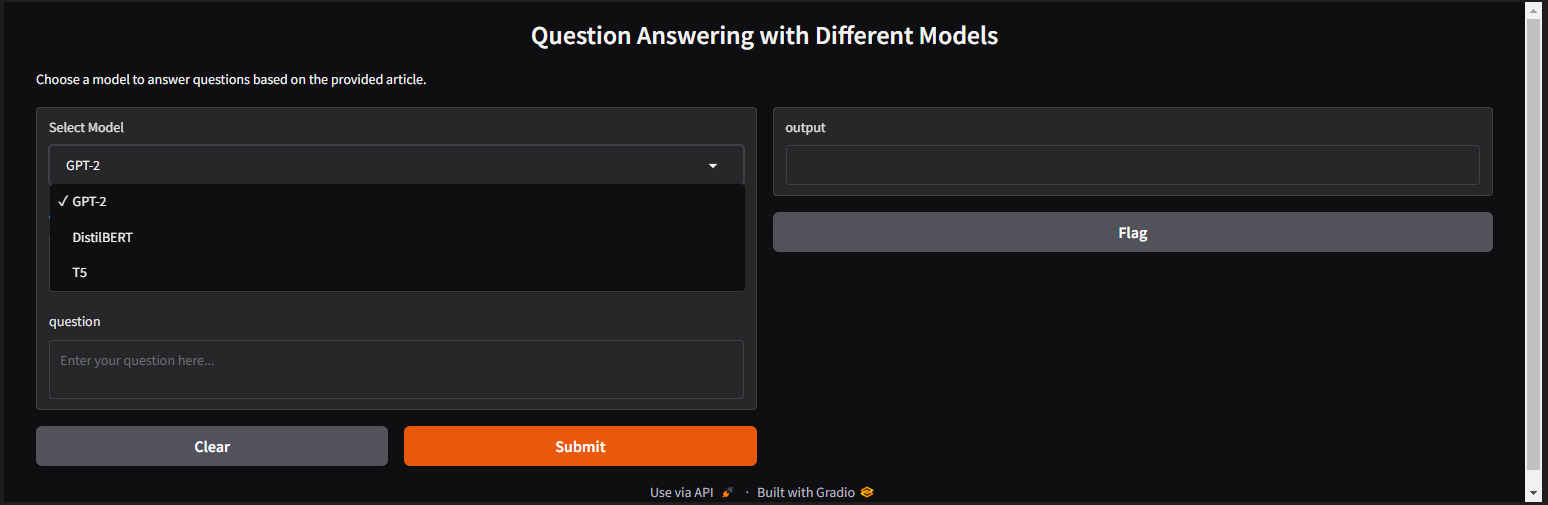

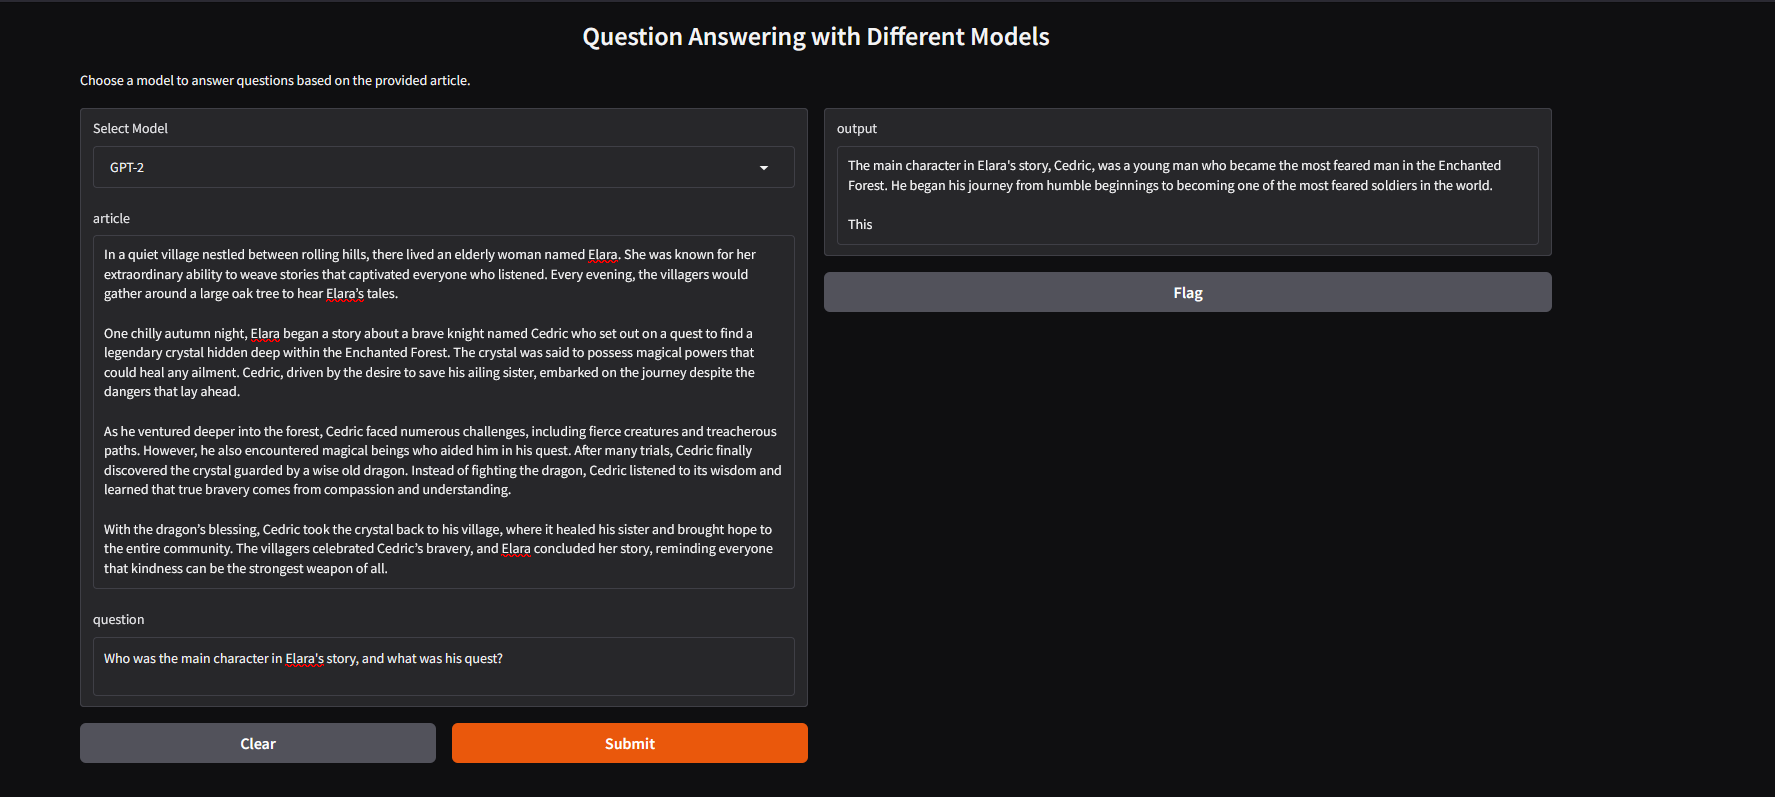

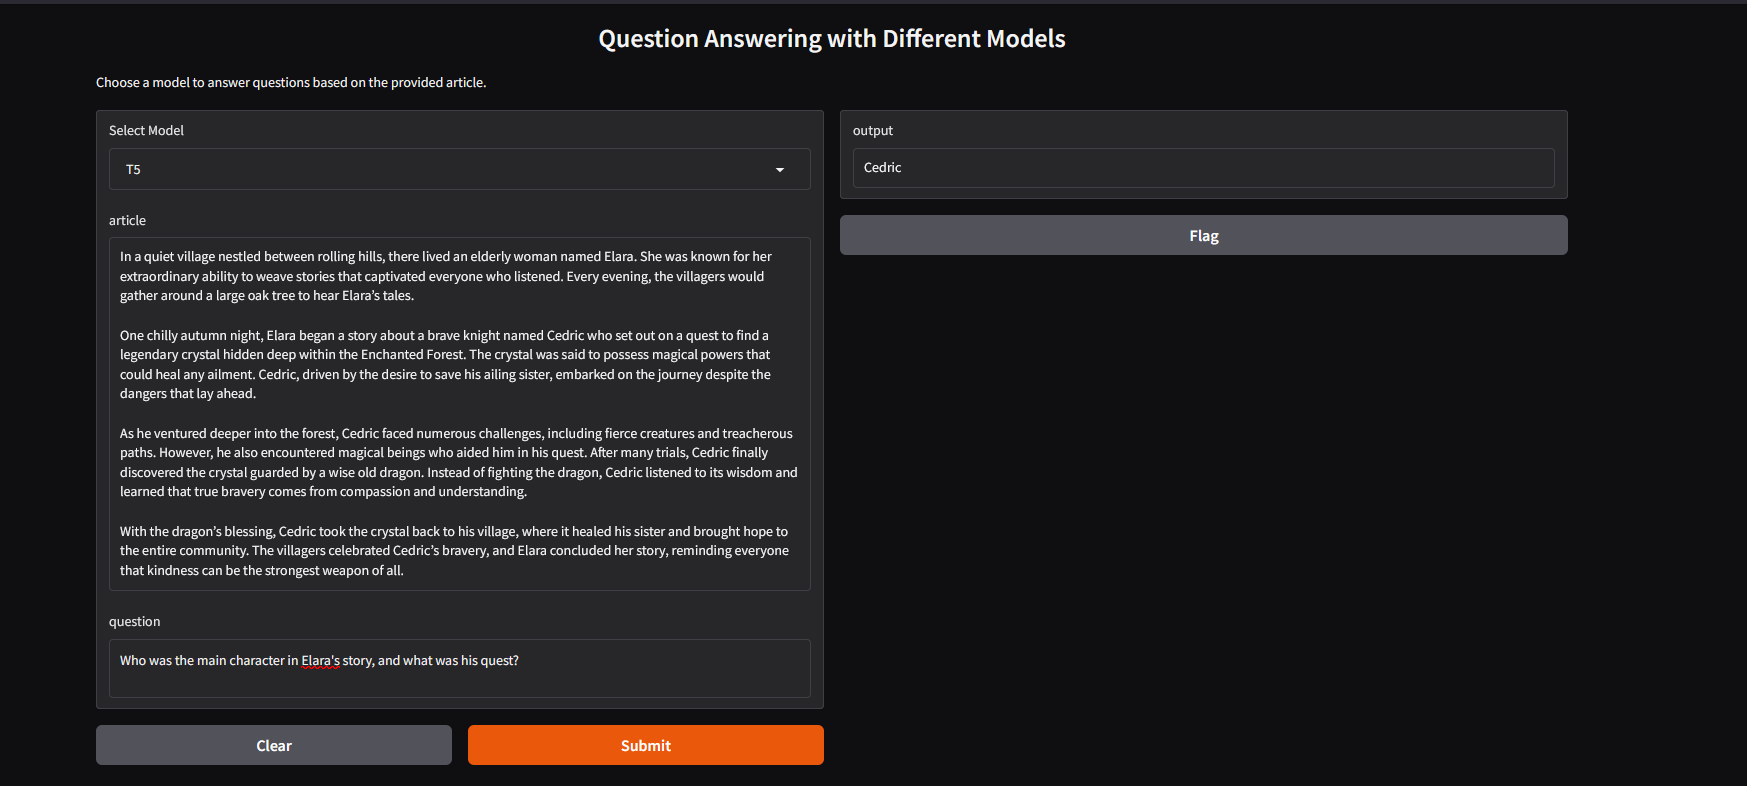

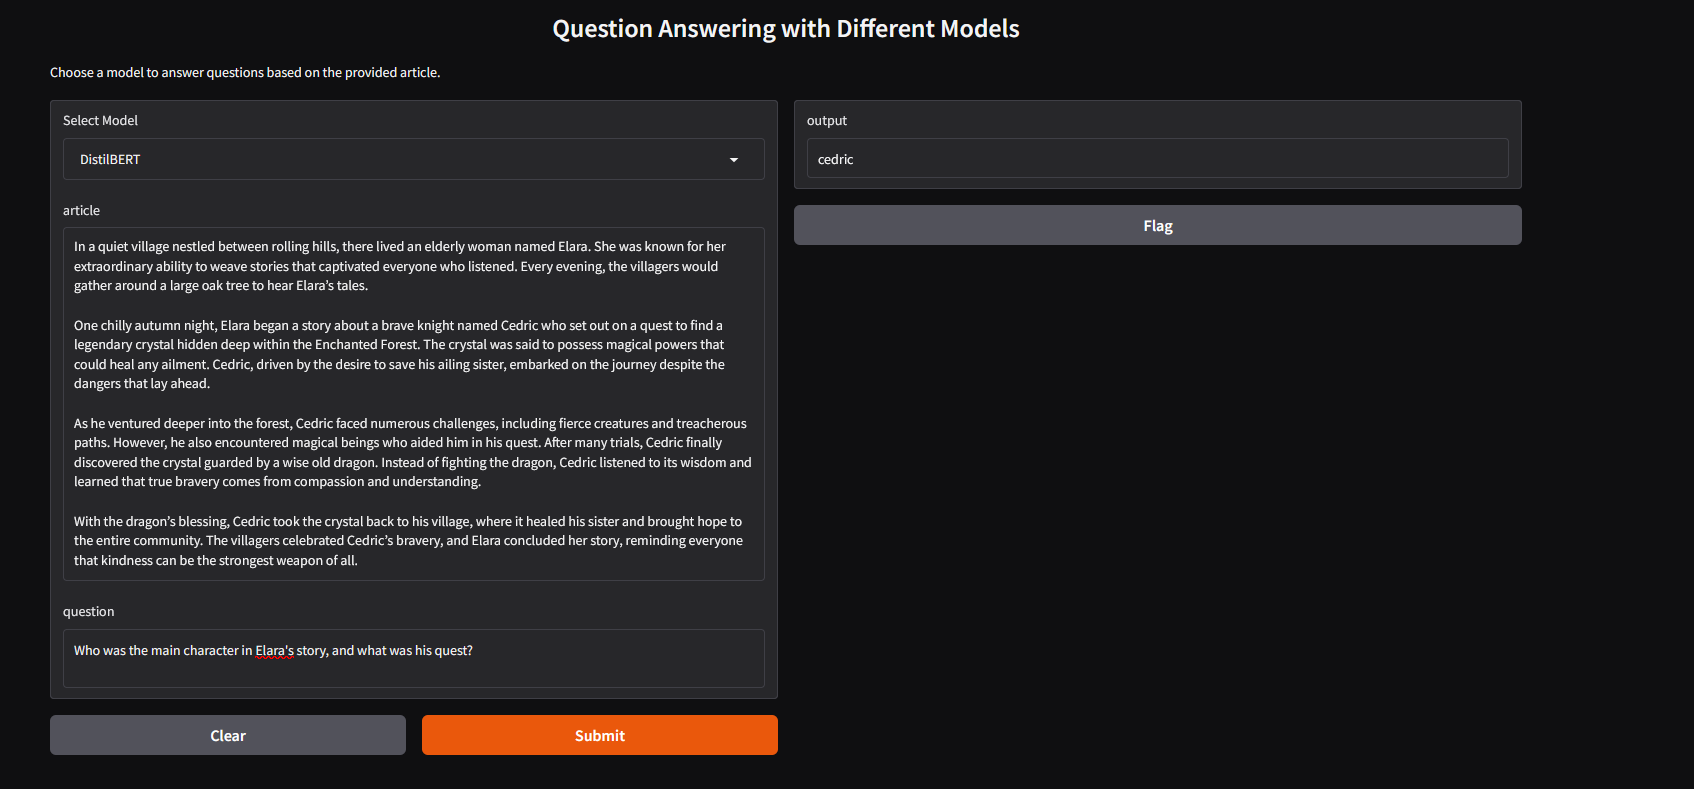